__**Table of Contents**__
====

>#### [12/18/2018](#12182018)

<a id='12182018'></a>

12/18/2018
====

>### I am now going to organize all of the calibration and quality cuts for the DDO51 photometry into a single function.

In [12]:
def calibr(cat):
    # Import modules
    from astropy.io import fits
    import numpy as np
    from astropy.table import Table

    #Loading data from night one
    z = fits.open(cat)
    
    #Loading dwarf locus data
    dat = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\gaiad51_dwarflocus.fits')
    
    #Remove all nans from photometry
    ind = np.where((~np.isnan(z[1].data['GAIA_BP']))&(~np.isnan(z[1].data['GAIA_RP']))&(~np.isnan(z[1].data['DDO51'])))
    z = z[1].data[ind]

    #Zero-point data
    #Calculate differences between photometric bands
    bprp = z['GAIA_BP']-z['GAIA_RP']
    bpd = z['GAIA_BP']-z['DDO51']

    #Create array with desired photometric data
    dt = np.dtype([('bprp',float),('bpd',float)])
    zerop = np.zeros(len(z['FILE']), dtype=dt)
    zerop['bprp'] = bprp
    zerop['bpd'] = bpd

    #Focus on values near the dwarf locus
    ind = np.where(zerop['bpd']<5)
    zerop = zerop[ind]
    hist, xedges, yedges = np.histogram2d(zerop['bprp'], zerop['bpd'], [50,50])
    ind = np.where(hist == hist.max())
    
    #Find the location of highest density in the locus
    x0 = xedges[ind[0]][0]
    y0 = yedges[ind[1]][0]
    good = np.where((zerop['bpd']<y0+0.15)&(zerop['bpd']>y0-0.68)&(zerop['bprp']<x0+2.17)&(zerop['bprp']>x0-0.574))

    #Determine the mean difference between expected BP-DDO51 and the BP-DDO51 in the observation file
    photint = np.interp(zerop['bprp'],dat['BPRP'],dat['BPD'])
    diff = zerop['bpd'] - photint
    m = np.mean(diff)

    #Adjusting DDO51 zero point
    mvec = [m]*len(z['DDO51'])
    z['DDO51'] += mvec

    #Applying all quality cuts
    ind = np.where((z['PID']>0)&                           # DDO51 detection
                   (z['PX']>0)&(z['PX']<2048)&           # DDO51 detection inside the CCD range
                   (z['PY']>0)&(z['PY']<4091)&
                   (z['SFLAGS']==0)&                       # Source Extractor flags
                   (z['DDO51']<50)&(z['DDO51']>1)&       # Has good DDO51 PSF photometry
                   (z['DDO51ERR']<0.3)&                    # Require okay errors
                   (z['GAIA_MATCH']==1)&                   # Require a Gaia DR2 match
                   (z['CHI']<3)&(abs(z['SHARP'])<1)&     # DAOPHOT quality and star/galaxy cuts
                   ((z['GAIA_ASTROMETRIC_EXCESS_NOISE']<3.1622)&(z['GAIA_GMAG']<=19)|(z['GAIA_GMAG']>19))&
                   ((z['GAIA_ASTROMETRIC_EXCESS_NOISE']<(3.1622 + (10**1.25-10**0.5)/4*(z['GAIA_GMAG']-19)))&
                   (z['GAIA_GMAG']>=19)|(z['GAIA_GMAG']<19)))       
    z = z[ind] 
    
    return(z)

In [13]:
test = calibr(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\munn\g12d111_xmatch_all.fits.gz')

In [14]:
len(test)

70462

>### I am most skeptical about whether the astrometric noise vs. magnitude cuts worked.  Below I reproduce an earlier plot to verify whether it worked as desired.

<IPython.core.display.Javascript object>


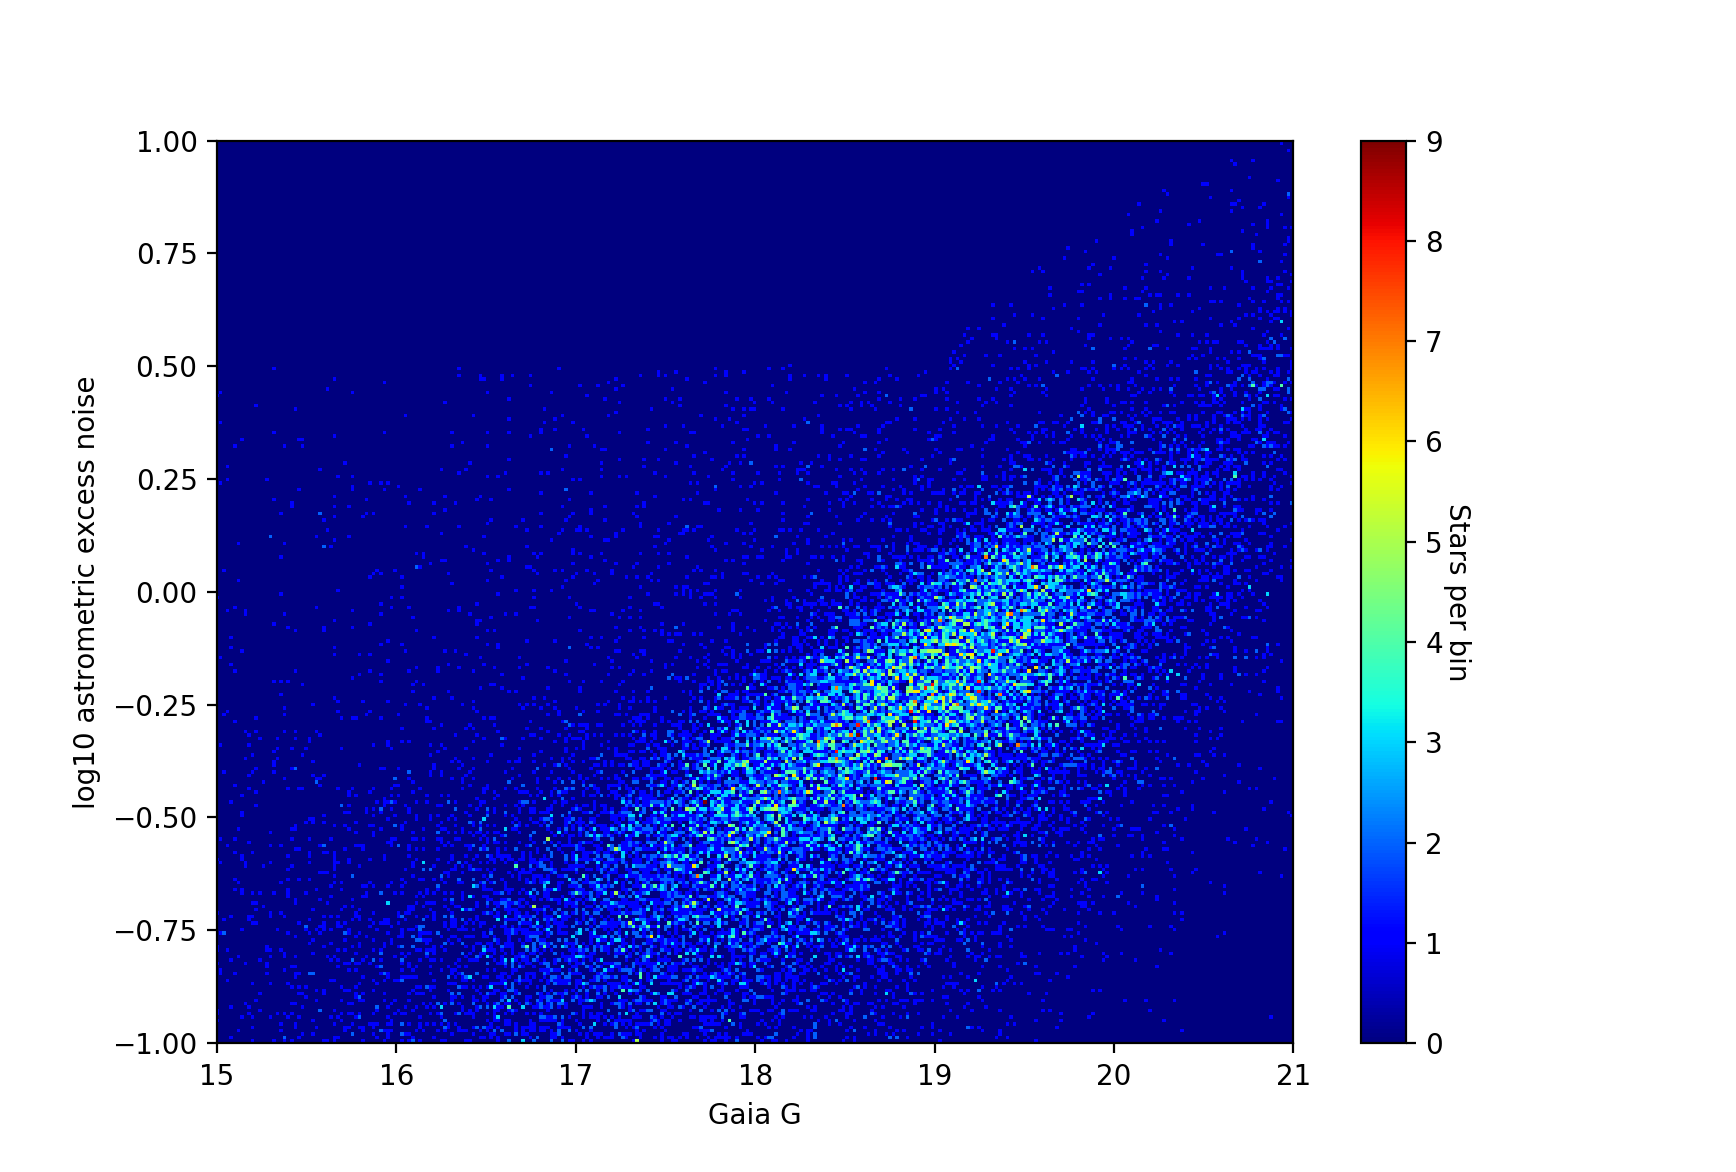

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

# Remove all zero points from y before taking log10
x = test['GAIA_GMAG']
y = test['GAIA_ASTROMETRIC_EXCESS_NOISE']

ind = np.where(y!=0)

x = x[ind]
y = y[ind]
y = np.log10(y)

plt.hist2d(x, y, (500, 500), cmap=plt.cm.jet)
cbar = plt.colorbar()
cbar.set_label('Stars per bin', rotation=270, labelpad=10)
plt.xlabel('Gaia G')
plt.ylabel('log10 astrometric excess noise')
plt.xlim(15,21)
plt.ylim(-1,1)
#plt.title('Adjusted Zero-Point', y=1.05)

plt.show()

<a id='12202018'></a>

12/20/2018
====

>### Below I dig in to individual fields in the fits file.  First I look at why there are nan values for mean offsets.  These fields returned nans when the average was computed
> * 0155
> * 0216
> * 0286

In [29]:
# Import modules
from astropy.io import fits
import numpy as np
from astropy.table import Table

#Loading data from night one
z = fits.open(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\munn\g12d111_xmatch_all.fits.gz')

#Loading dwarf locus data
dat = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\gaiad51_dwarflocus.fits')

ind = np.where(z[1].data['file']=='g12d111.0155')
z = z[1].data[ind]

In [32]:
#Remove all nans from photometry
ind = np.where((~np.isnan(z['GAIA_BP']))&(~np.isnan(z['GAIA_RP']))&(~np.isnan(z['DDO51'])))
z = z[ind]

#Zero-point data
#Calculate differences between photometric bands
bprp = z['GAIA_BP']-z['GAIA_RP']
bpd = z['GAIA_BP']-z['DDO51']

#Create array with desired photometric data
dt = np.dtype([('bprp',float),('bpd',float)])
zerop = np.zeros(len(z['FILE']), dtype=dt)
zerop['bprp'] = bprp
zerop['bpd'] = bpd

#Focus on values near the dwarf locus
ind = np.where(zerop['bpd']<5)
zerop = zerop[ind]
hist, xedges, yedges = np.histogram2d(zerop['bprp'], zerop['bpd'], [50,50])
ind = np.where(hist == hist.max())

#Find the location of highest density in the locus
x0 = xedges[ind[0]][0]
y0 = yedges[ind[1]][0]
good = np.where((zerop['bpd']<y0+0.15)&(zerop['bpd']>y0-0.68)&(zerop['bprp']<x0+2.17)&(zerop['bprp']>x0-0.574))

photint = np.interp(zerop['bprp'],dat['BPRP'],dat['BPD'])
diff = zerop['bpd'] - photint
m = np.mean(diff)

C:\Users\shebe\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shebe\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
zerop['bpd']

array([], dtype=float64)

>### It looks like the nans are due to lack of data points in the field.  Below I make a plot of the field to investigate further.

<IPython.core.display.Javascript object>


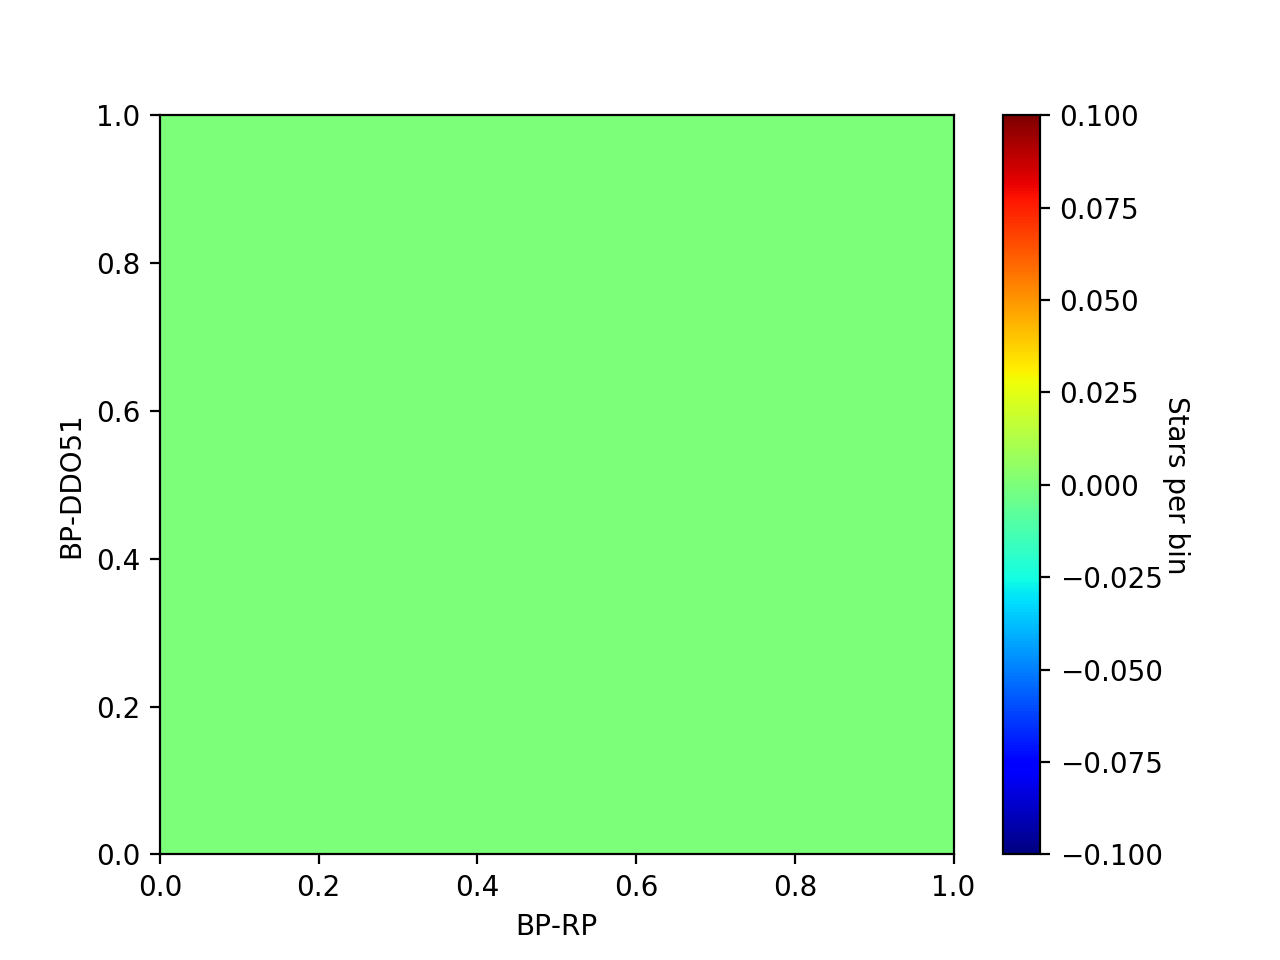

In [58]:
%matplotlib nbagg

from astropy.io import fits
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt


g12 = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\munn\g12d111_xmatch_all.fits.gz')

#Remove nans from data
ind = np.where((~np.isnan(g12['GAIA_BP']))&
               (~np.isnan(g12['GAIA_RP']))&
               (~np.isnan(g12['DDO51'])))
g12 = g12[ind]

#Filter down to single field
ind = np.where(g12['FILE']=='g12d111.0155')
g12 = g12[ind]

#Calculate differences between photometric bands
bprp = g12['GAIA_BP']-g12['GAIA_RP']
bpd = g12['GAIA_BP']-g12['DDO51']

#Create array with desired photometric data
dt = np.dtype([('bprp',float),('bpd',float)])
phot = np.zeros(len(g12), dtype=dt)
phot['bprp'] = bprp
phot['bpd'] = bpd

#Remove bad values (equal to zero or greater than 100)
ind = np.where((phot['bprp']<100)&(phot['bpd']<100))
phot = phot[ind]

x = phot['bprp']
y = phot['bpd']

plt.hist2d(x, y, (50, 50), cmap=plt.cm.jet)
cbar = plt.colorbar()
cbar.set_label('Stars per bin', rotation=270, labelpad=10)
plt.xlabel('BP-RP')
plt.ylabel('BP-DDO51')

plt.show()

>### The issue is that all the values for GAIA_BP and GAIA_RP are bad in these fields.  To confirm this, I create an array with the number of entries per field.

In [72]:
# Import modules
from astropy.io import fits
from astropy.table import Table
import numpy as np

#Loading data from night one
z = fits.open(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\munn\g12d111_xmatch_all.fits.gz')

#loading dwarf locus data
dat = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\gaiad51_dwarflocus.fits')

#Create a new fits table with a field column and mean column
uni = np.unique(z[1].data['FILE'])
field = np.array(uni)
dt = np.dtype([('mean',float)])
mean = np.zeros(len(uni))
col1 = fits.Column(name='field', format='A15', array=field)
col2 = fits.Column(name='mean', format='E10', array=mean)
coldefs = fits.ColDefs([col1, col2])
hdu = fits.BinTableHDU.from_columns(coldefs)

#Remove nans from data
ind = np.where((~np.isnan(z[1].data['GAIA_BP']))&
               (~np.isnan(z[1].data['GAIA_RP']))&
               (~np.isnan(z[1].data['DDO51'])))
z = z[1].data[ind]

for i in hdu.data['field']:

    #Indices
    ind = np.where(z['FILE']==i)

    #Subset in the same field
    sub = z[ind]

    #Zero-point data
    #Calculate differences between photometric bands
    bprp = sub['GAIA_BP']-sub['GAIA_RP']
    bpd = sub['GAIA_BP']-sub['DDO51']

    #Create array with desired photometric data
    dt = np.dtype([('bprp',float),('bpd',float)])
    zerop = np.zeros(len(sub), dtype=dt)
    zerop['bprp'] = bprp
    zerop['bpd'] = bpd

    #Focus on values near the dwarf locus
    ind = np.where((zerop['bprp']<3)&(zerop['bpd']<3))
    zerop = zerop[ind]
    hist, xedges, yedges = np.histogram2d(zerop['bprp'],zerop['bpd'], [50,50])
    ind = np.where(hist == hist.max())
    #Find the location of highest density in the locus
    x0 = xedges[ind[0]][0]
    y0 = xedges[ind[1]][0]
    good = np.where((zerop['bpd']<y0+0.15)&(zerop['bpd']>y0-0.68)&(zerop['bprp']<x0+2.17)&(zerop['bprp']>x0-0.574))
    zerop = zerop[good]

    #Determine the number of entries per field
    ind = np.where(hdu.data['field']==i)
    hdu.data['number of entries'][ind] = len(zerop[ind])

KeyError: "Key 'number of entries' does not exist."

In [71]:
hdu